## Written by Jonas Chan Leong Sean for the Udacity Self Driverless Car Course for the project: Vehicle Detection

### The final video is in the project submission directory and is titled:

### output.mp4
    
    


# Import Required Libraries

To begin with, I first import all the libraries required for the functionality of the
project.

In [1]:
import cv2
import glob
import pickle
import time
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage.feature import hog
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline

# Import Data

In the following cell, using the 'glob' library, I import all the car and non-cars images
which are located in the training_images folder in the project directory.

Here we also compute the size of the dataset and found that we have 8792 car images and 8968 non-car images

In [2]:
debug = True
car_path = glob.glob('training_images/vehicles/**/*.png')
not_car_path = glob.glob('training_images/non-vehicles/**/*.png')
total_cars = len(car_path)
total_non_cars = len(not_car_path)
if (debug):
    print('The total amount of cars images for training is: ' + str(total_cars))
    print('The total amount of non - car images for training is: ' + str(total_non_cars))

The total amount of cars images for training is: 8792
The total amount of non - car images for training is: 8968


# Data Exploration

As always, the input data are first explored. The 'explore_input_data' function first generates a random integer between 0 to the total number of cars and total number of non-cars. Using the randomly generated number for both car and non-cars repectively, a random image from the imported datasets are selected which are then displayed using the matplotlib 'imshow' function as illustrated in the output below. The car is titled "Car image" and the other, "Non-car image"

Here we see that both images; car and non-cars have similar shapes of 64 X 64 with a depth of 3 which is fairly obvious since they are coloured images.

In [3]:
def explore_input_data(title_1, title_2, cars, not_cars):
    
    car_ind = np.random.randint(0, total_cars)
    notcar_ind = np.random.randint(0, total_non_cars)
    
    random_car_image = mpimg.imread(cars[car_ind])
    random_non_car_image = mpimg.imread(not_cars[notcar_ind])
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
    f.tight_layout()

    ax1.set_title(title_1, fontsize=30)
    ax1.imshow(random_car_image)
    
    ax2.set_title(title_2, fontsize=30)
    ax2.imshow(random_non_car_image)
    
    print('Shape of car image: ' + str(random_car_image.shape))
    print('Shape of non-car image: ' + str(random_non_car_image.shape))
    print('Car image type: ' + str(random_car_image.dtype))
    print('Non-car image type: ' + str(random_non_car_image.dtype))

Shape of car image: (64, 64, 3)
Shape of non-car image: (64, 64, 3)
Car image type: float32
Non-car image type: float32


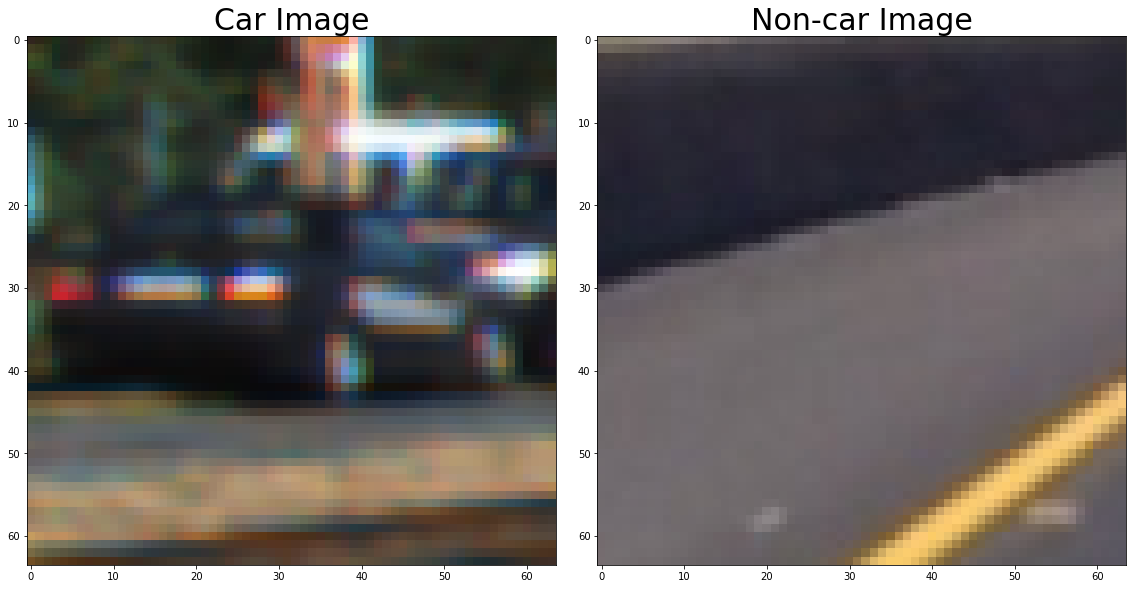

In [4]:
explore_input_data('Car Image', 'Non-car Image', car_path, not_car_path)

# Feature Extraction

In this section of the notebook, I first include all the functions in the lessons, including get_hog_features, bin_spatial and color_hist.

The purposes of each functions and some notable parameters are described below:

## get_hog_features
The scikit-image hog() function takes in a single color channel or grayscaled image as input, as well as various parameters. These parameters include orientations, pixels_per_cell and cells_per_block.

The number of **orientations** is specified as an integer, and represents the number of orientation bins that the gradient information will be split up into in the histogram. Typical values are between 6 and 12 bins.

The **pixels_per_cell** parameter specifies the cell size over which each gradient histogram is computed. This paramater is passed as a 2-tuple so you could have different cell sizes in x and y, but cells are commonly chosen to be square.

The **cells_per_block** parameter is also passed as a 2-tuple, and specifies the local area over which the histogram counts in a given cell will be normalized. Block normalization is not necessarily required, but generally leads to a more robust feature set.

There is another optional **power law** or "gamma" normalization scheme set by the flag transform_sqrt. This type of normalization may help reduce the effects of shadows or other illumination variation, but will cause an error if your image contains negative values (because it's taking the square root of image values).

## bin_spatial
The bin_spatial function performs two main functions; reducing the resolution of the image and converting the image to a one dimensional feature vector. The feature vector obtained from this function is used to train the classifier.

## color_hist
This function takes an image and computes the RGB color histogram of features given a particular number of bins and pixels intensity range, and returns the concatenated RGB feature vector.

In [5]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, 
                                  orientations = orient, 
                                  pixels_per_cell = (pix_per_cell, pix_per_cell),
                                  cells_per_block = (cell_per_block, cell_per_block), 
                                  transform_sqrt = True, 
                                  visualise=vis, 
                                  feature_vector = feature_vec)
        
        return features, hog_image

    else:      
        features = hog(img, 
                       orientations = orient, 
                       pixels_per_cell = (pix_per_cell, pix_per_cell),
                       cells_per_block = (cell_per_block, cell_per_block), 
                       transform_sqrt = True, 
                       visualise = vis,
                       feature_vector = feature_vec)
        
        return features

def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Combining Feature Extractions

In this section of the notebook, I include another function which is used to extract the features from the raw images, albeit the car and non-car images. As shown in the cell below, I have chosen to include spatial features, the color histogram as well as including in the HOG implementation for better feature extractions.

In [6]:
def extract_features(imgs, color_space = 'RGB', 
                     spatial_size = (32, 32), hist_bins = 32, orient = 9,
                     pix_per_cell = 8, cell_per_block = 2, hog_channel = 0,
                     include_spatial_features = True, include_color_histogram_features = True, 
                     include_HOG_features = True):
    
    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        
        # Read in each one by one
        image = mpimg.imread(file)
        
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
                
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
                
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
                
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
                
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
                
        else: 
            feature_image = np.copy(image)      

        if include_spatial_features:
            spatial_features = bin_spatial(feature_image, size = spatial_size)
            file_features.append(spatial_features)
        
        if include_color_histogram_features:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins = hist_bins)
            file_features.append(hist_features)
        
        if include_HOG_features:
            if hog_channel == 'ALL':
                hog_features = []
                
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel], 
                                        orient, 
                                        pix_per_cell, 
                                        cell_per_block, 
                                        vis = False, 
                                        feature_vec=True))
                
                hog_features = np.ravel(hog_features)        
            
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], 
                                                orient, 
                                                pix_per_cell, 
                                                cell_per_block, 
                                                vis = False, 
                                                feature_vec = True)
                
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        
        features.append(np.concatenate(file_features))
    
    # Return list of feature vectors
    return features

# Visualising HOG

In this section of the notebook, I explore the relationship between different color spaces with respect to the HOG output as well as the relationship between the color space channels with respect to the HOG output. 

Using HOG parameters of orient = 9, pix_per_cell = 8 and cell_per_block = 2, I produced a total of 27 output images to help visualise the relationships mentioned. **Based on this, I concluded that the "YCrCb" color space is a much better option than either "RGB" or "HLS" since it produced a much better HOG output where visible features such as edges of the vehicles and the non-car images are still visible in the HOG output image. On the other hand, HLS seemed to work similarly well with the chosen one whereas the RGB color channel was discarded since under changing light conditions as per the project video, it seemed to perform poorly **

In addition to that, the **HOG parameters were chosen based on multiple attempts and found that the values chosen here were much better when compared to the rest of my tests. Based on my tests, I found that by increasing the orient parameter, the feature vector increased as well but had almost similar effect as 9 and so I chose this value instead. This also applies to the cells_per_block parameter.**

In [107]:
def visualiseHOG(img_path, title_1, title_2, title_3, channel, color_space):
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    
    raw_image = mpimg.imread(img_path)
    
    if color_space == "HLS":
        gray_raw_image = cv2.cvtColor(raw_image, cv2.COLOR_RGB2HLS)[:, :, channel]
    elif color_space == "RGB":
        gray_raw_image = raw_image[:, :, channel]
    elif color_space == "YCrCb":
        gray_raw_image = cv2.cvtColor(raw_image, cv2.COLOR_RGB2YCrCb)[:, :, channel]
    
    HOG_output = get_hog_features(gray_raw_image, 
                                 orient, 
                                 pix_per_cell, 
                                 cell_per_block, 
                                 vis = True, 
                                 feature_vec = False)
    
    HOG_image = HOG_output[1]
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 9))
    f.tight_layout()

    ax1.set_title(title_1, fontsize = 15)
    ax1.imshow(raw_image)
    
    ax2.set_title(title_2, fontsize = 15)
    ax2.imshow(gray_raw_image, cmap = 'gray')
    
    ax3.set_title(title_3, fontsize = 15)
    ax3.imshow(HOG_image, cmap = 'gray')

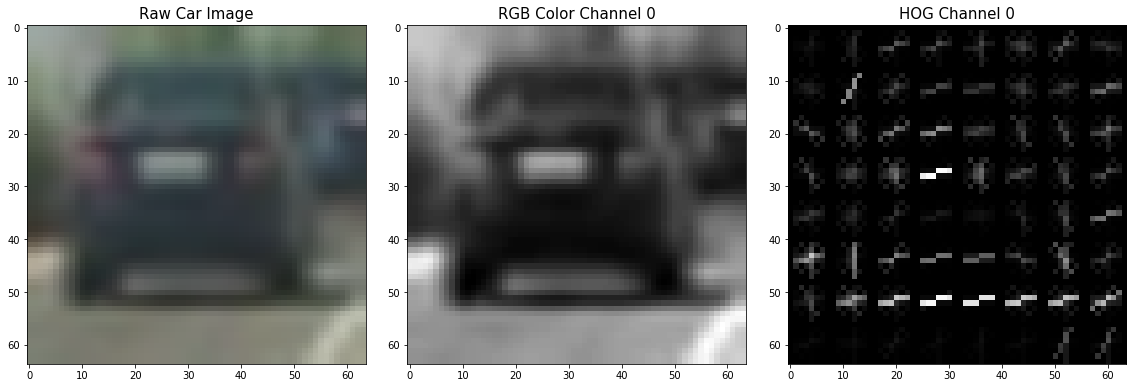

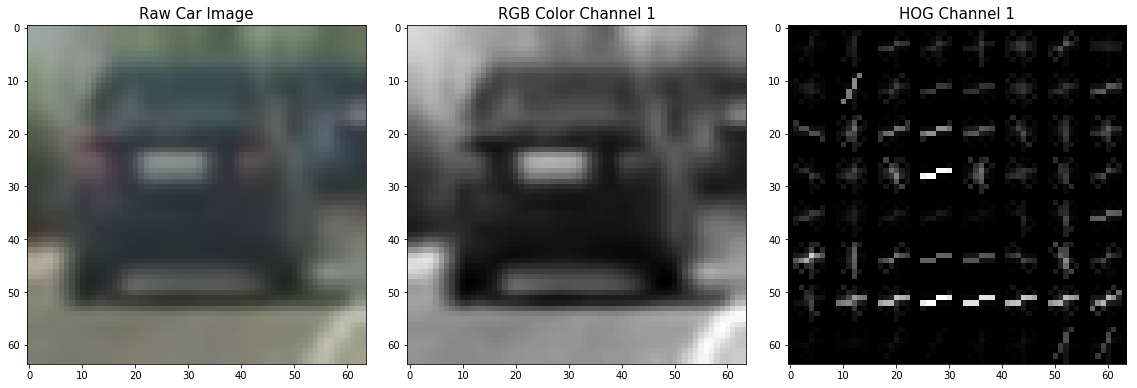

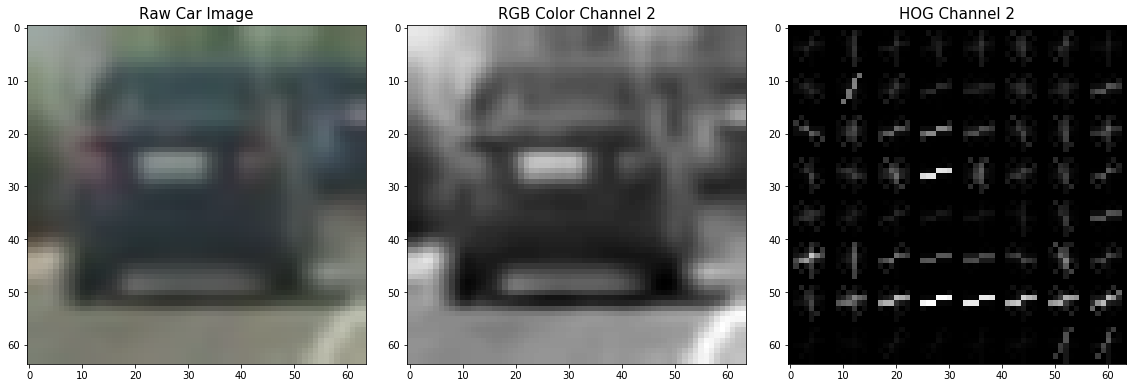

In [111]:
car_ind = np.random.randint(0, total_cars)

for i in range(3):
    visualiseHOG(car_path[0], 'Raw Car Image', 'RGB Color Channel ' + str(i), "HOG Channel " + str(i), i, "RGB")

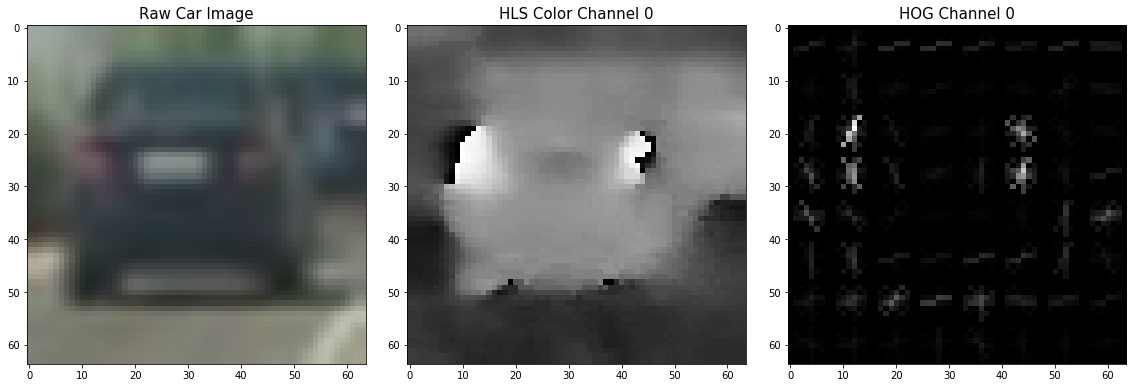

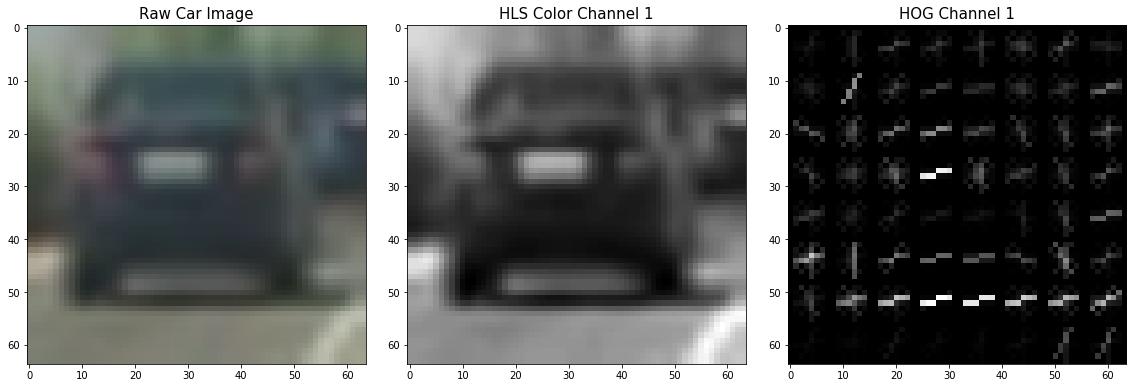

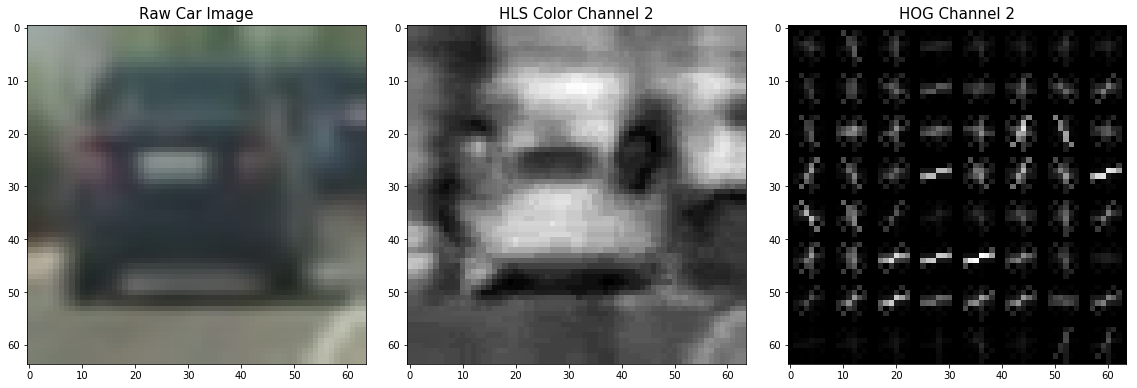

In [113]:
car_ind = np.random.randint(0, total_cars)

for i in range(3):
    visualiseHOG(car_path[0], 'Raw Car Image', 'HLS Color Channel ' + str(i), "HOG Channel " + str(i), i, "HLS")

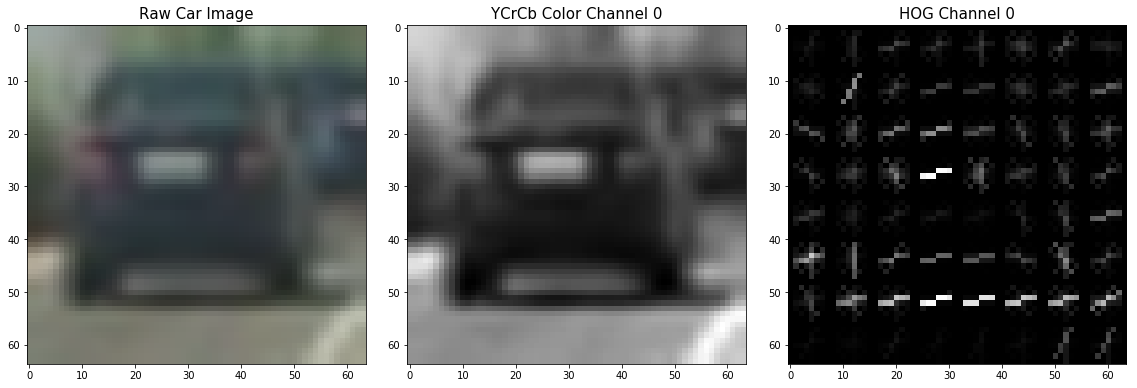

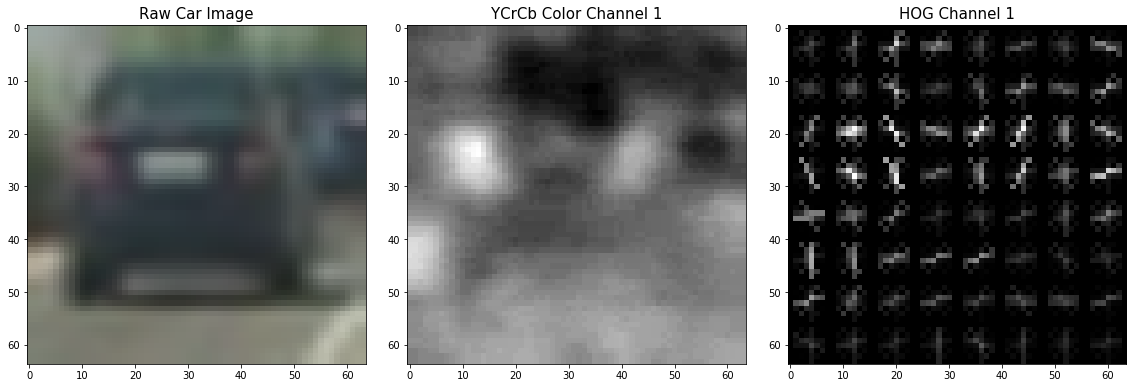

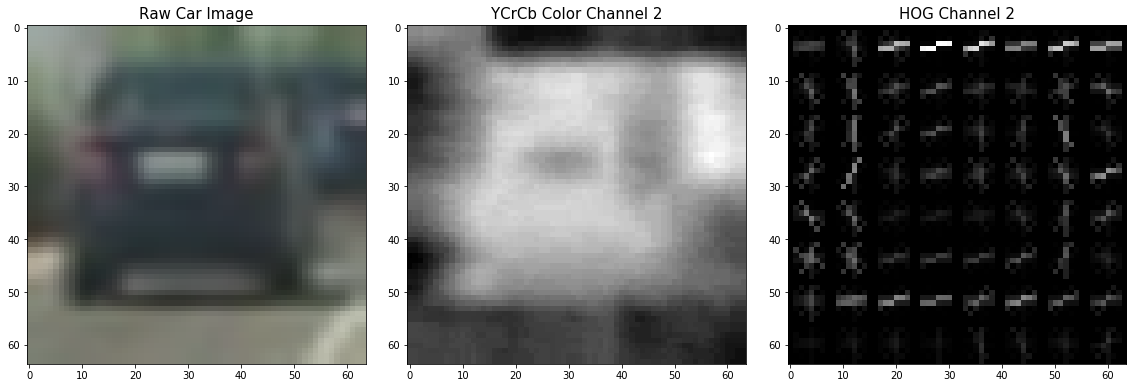

In [114]:
car_ind = np.random.randint(0, total_cars)

for i in range(3):
    visualiseHOG(car_path[0], 'Raw Car Image', 'YCrCb Color Channel ' + str(i), "HOG Channel " + str(i), i, "YCrCb")

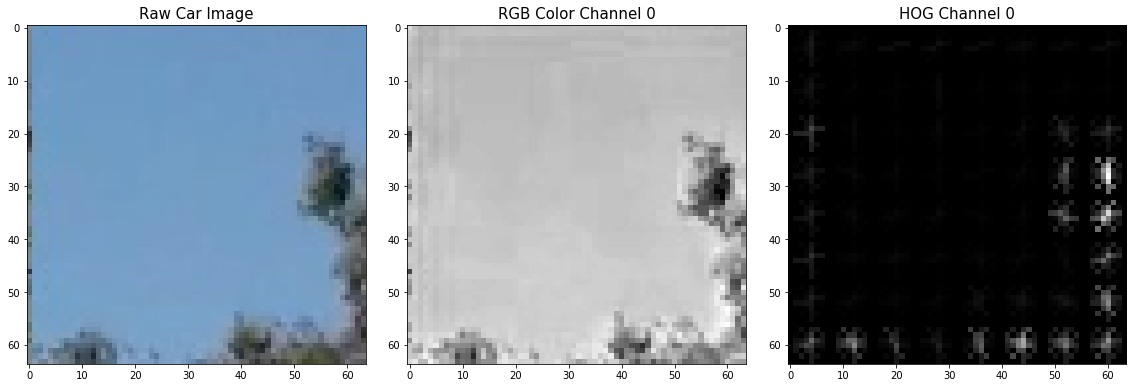

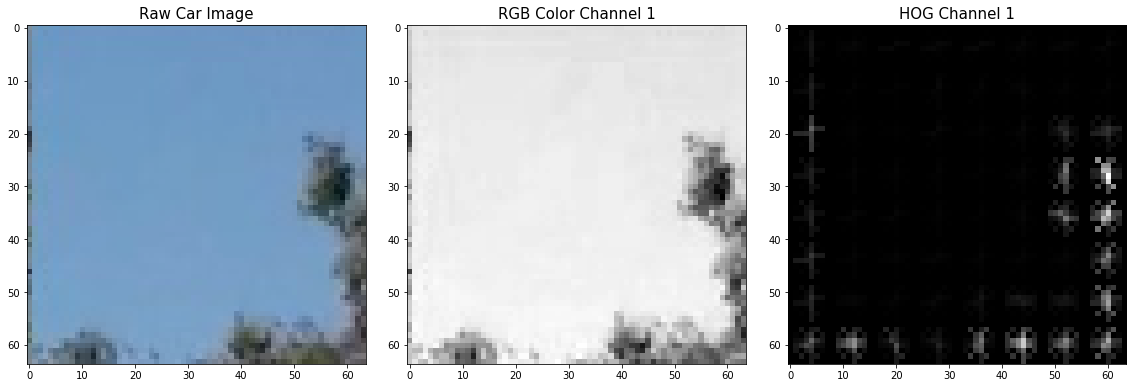

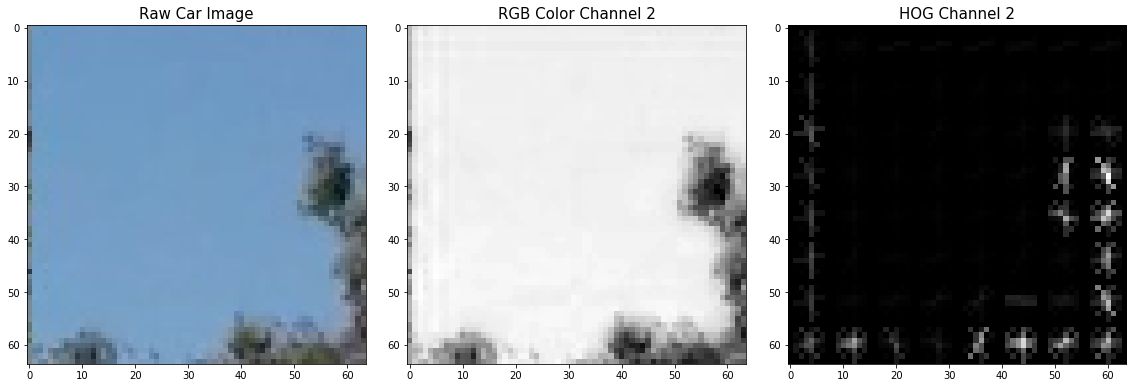

In [115]:
notcar_ind = np.random.randint(0, total_non_cars)

for i in range(3):
    visualiseHOG(not_car_path[0], 'Raw Car Image', 'RGB Color Channel ' + str(i), "HOG Channel " + str(i), i, "RGB")

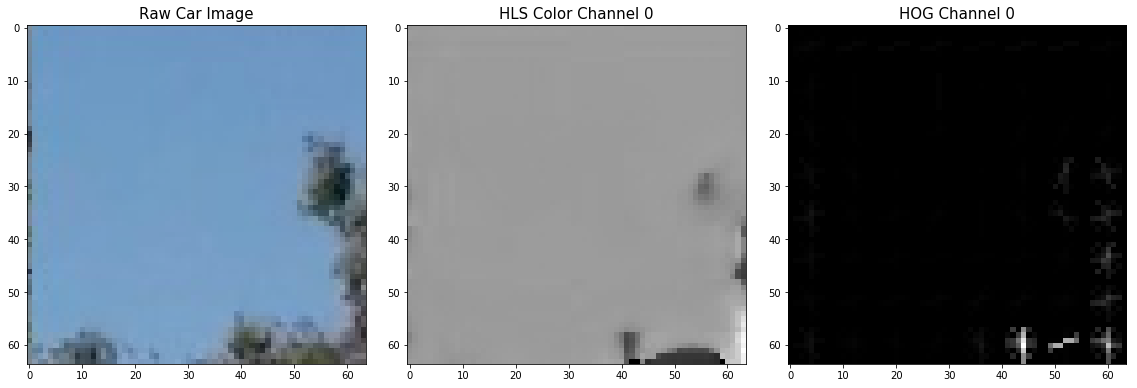

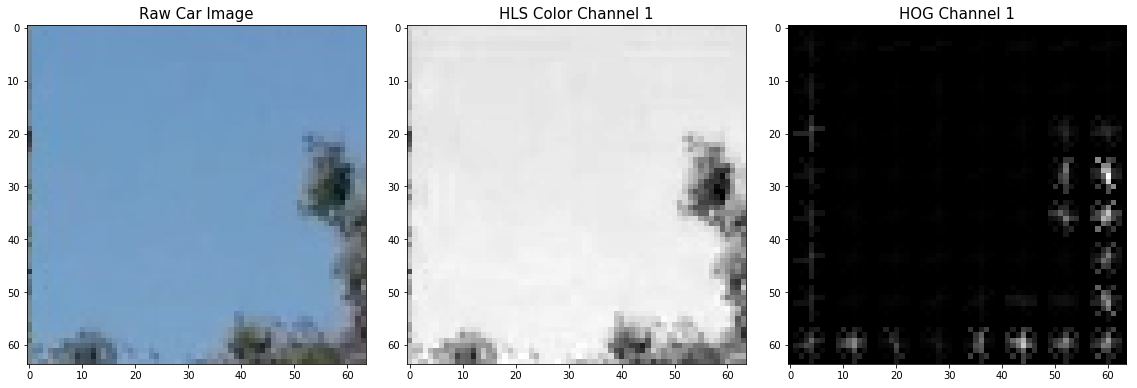

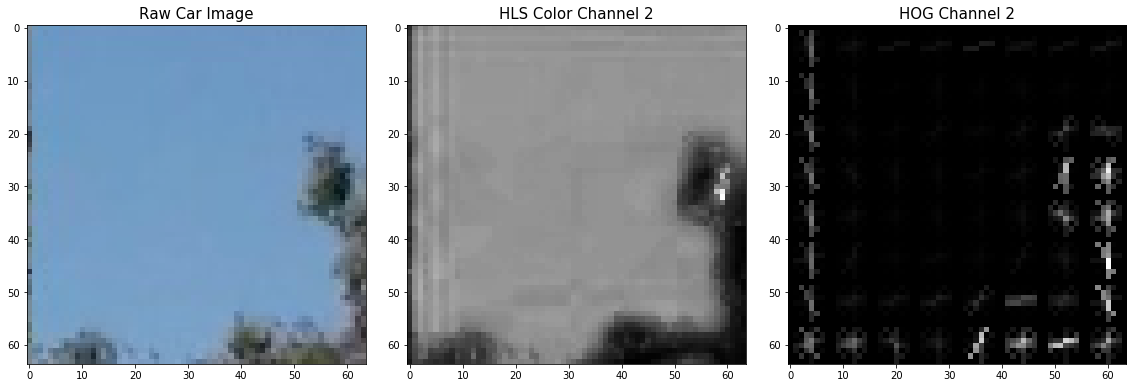

In [116]:
notcar_ind = np.random.randint(0, total_non_cars)

for i in range(3):
    visualiseHOG(not_car_path[0], 'Raw Car Image', 'HLS Color Channel ' + str(i), "HOG Channel " + str(i), i, "HLS")

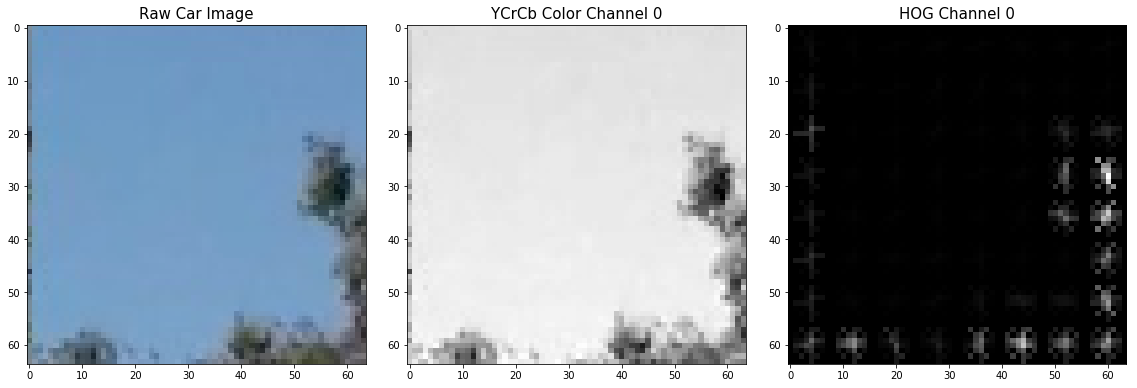

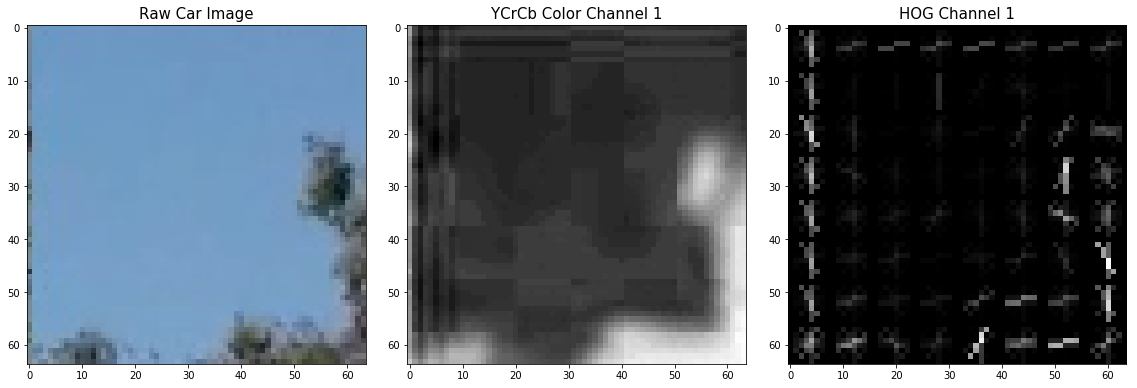

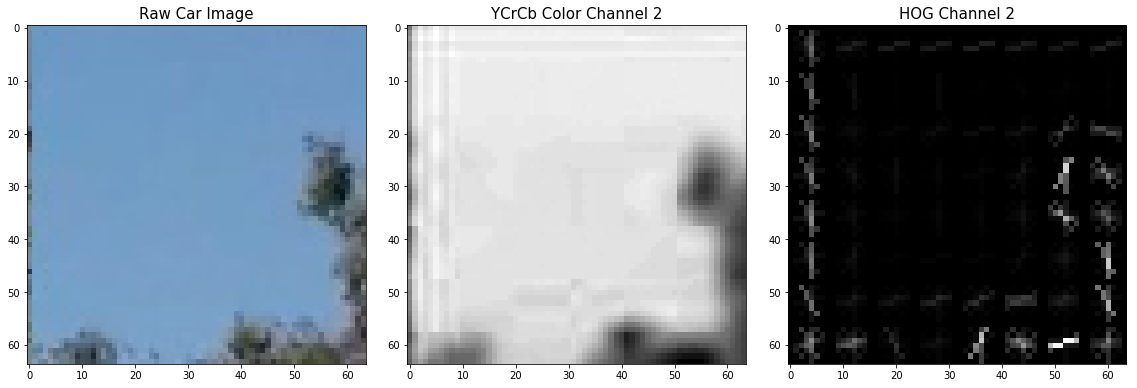

In [117]:
notcar_ind = np.random.randint(0, total_non_cars)

for i in range(3):
    visualiseHOG(not_car_path[0], 'Raw Car Image', 'YCrCb Color Channel ' + str(i), "HOG Channel " + str(i), i, "YCrCb")

# Training an SVC Classifier

Using the paramters found above, I then proceeded to train the classifier. The classifier chosen is the LinearSVC classfier as shown in the lessons. As mentioned in the above, the feature extraction fed into the classifier includes color features, spatial features, as well as HOG features using the YCrCb colorspace. On the HOG channels, I chose to use all the color channels instead of individual color channels since they had much higher test accuracy compared to the former.

<p>**Hence, the parameters used to train the classifier are:**</p>
<p>colorspace = "YCrCb",</p>
<p>orient = 9,</p>
<p>pix_per_cell = 8,</p>
<p>cell_per_block = 2,</p>
<p>HOG_channel = "ALL"</p>


<p>**Using these parameters, the classifier:**</p>

<p>Took 84.08 seconds to obtain extracted features, </p>
<p>Took 11.33 seconds to train SVC, </p>
<p>Completed with a Test Accuracy of SVC:  0.9896/ 98.96% </p>


In [10]:
def obtain_extracted_features():
    colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    start_time = time.time()
    
    car_features = extract_features(car_path, 
                                    color_space = colorspace, 
                                    orient = orient, 
                                    pix_per_cell = pix_per_cell, 
                                    cell_per_block = cell_per_block, 
                                    hog_channel = hog_channel)

    non_car_features = extract_features(not_car_path, 
                                        color_space = colorspace, 
                                        orient = orient, 
                                        pix_per_cell = pix_per_cell, 
                                        cell_per_block = cell_per_block, 
                                        hog_channel = hog_channel)
    
    end_time = time.time()
    
    print('Time(seconds) to obtain extracted features: ' + str(round(end_time - start_time, 2)))
    
    return car_features, non_car_features

In [11]:
def create_feature_vector_array_stack(car_features, non_car_features):
    # Create an array stack of feature vectors
    X = np.vstack((car_features, non_car_features)).astype(np.float64)                        
    
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    
    # Define the labels vector
    label_vector = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))
    
    return scaled_X, label_vector, X_scaler

In [12]:
def train_classifier(scaled_X, label_vector, X_scaler):
    print("Training Classifier...")
    
    test_size = 0.2
    
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, 
                                                        label_vector, 
                                                        test_size = test_size, 
                                                        random_state = rand_state)

    print('Feature vector length:', len(X_train[0]))
    
    # Use a linear SVC 
    svc = LinearSVC()
    
    # Check the training time for the SVC
    start_time = time.time()
    
    svc.fit(X_train, y_train)
    
    end_time = time.time()
    
    print('Time(seconds) to train SVC: ' + str(round(end_time - start_time, 2)))
    
    # Check the score of the SVC
    print('Test Accuracy of SVC: ', str(round(svc.score(X_test, y_test), 4)))
    
    print("Completed training classifier! Saving training data...")
    pickle.dump({ 'svc': svc, 'scaler': X_scaler }, open('model.p', 'wb'))
    print("Training data saved!")

In [13]:
def begin_training_classifier():
    car_features, non_car_features = obtain_extracted_features()  
    vector_array_stack = create_feature_vector_array_stack(car_features, non_car_features)    
    train_classifier(vector_array_stack[0], vector_array_stack[1], vector_array_stack[2])

In [14]:
begin_training_classifier()

Time(seconds) to obtain extracted features: 84.08
Training Classifier...
Feature vector length: 8460
Time(seconds) to train SVC: 11.33
Test Accuracy of SVC:  0.9896
Completed training classifier! Saving training data...
Training data saved!


# Sliding Window Implementation

<p>As for the sliding window, I used a multi-scale HOG sub sampling window search technique where the search parameter included *almost* the bottom half of the image where only necessary regions (regions where cars and potential cars may be at a particular time) are taken into account.</p>  

<p>**Hence my search window is taken from: ** </p>
<p>x_min = 0, x_max = max of the image, </p>
<p>y_min = 400, y_max = 656 </p> 

<p>The **find_cars function** only has to extract hog features once and then can be sub-sampled to get all of its overlaying windows. Each window is defined by a scaling factor where a scale of 1 would result in a window that's 8 x 8 cells then the overlap of each window is in terms of the cell distance. This means that a cells_per_step = 2 would result in a search window overlap of 75%. Its possible to run this same function multiple times for different scale values to generate multiple-scaled search windows.</p>

<p> Based on multiple attempts, I concluded on using scales [1, 1.5, 1.7, 2]. Based on these scale values, I store the scales into one function called **store_all_found_boxes** which are then all drawn over the images again using the **overlay_boxes** function. I have plotted the output in the corresponding image below. </p>

<p> From the output images shown below, based on the values chosen, it can be seen of the occurance of some false positives on the side rails, a certain portion of the lane and some vehicles on the opposite direction but fortunately the majority of the windows were focused on the vehicles </p>

In [15]:
def slide_window(img, x_start_stop = [None, None], 
                 y_start_stop = [None, None], xy_window = (64, 64), 
                 xy_overlap = (0.5, 0.5)):
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def overlay_boxes(img, boxes, color = (0, 0, 255), line_thickness = 6):
    # Make a copy of the image
    raw_image = np.copy(img)
    
    # Iterate through the bounding boxes
    for box in boxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(raw_image, box[0], box[1], color, line_thickness)
    
    # Return the image copy with boxes drawn
    return raw_image

(720, 1280, 3)


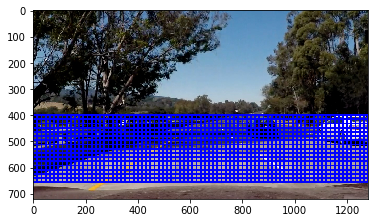

In [52]:
def test_window_search():
    image = mpimg.imread('test_images/test5.jpg')
    img_shape = image.shape
    
    windows = slide_window(image, x_start_stop=[0, img_shape[1]], y_start_stop=[400, 656], 
                        xy_window=(64, 64), xy_overlap=(0.75, 0.75))

    window_img = overlay_boxes(image, windows, color=(0, 0, 255), line_thickness = 6)                    
    
    print(img_shape)
    plt.imshow(window_img)
    
test_window_search()

# HOG Sub-sampling Window Search

In [53]:
# Load saved data
model_pickle = pickle.load(open('model.p', 'rb'))
svc = model_pickle['svc']
X_scaler = model_pickle['scaler']

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, scale = 1.5, svc = svc, X_scaler = X_scaler, ystart = 400, ystop = 656, orient=9, 
              pix_per_cell = 8, cell_per_block = 2, spatial_size = (32, 32), hist_bins = 32):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255 
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1 
    nfeat_per_block = orient * cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    found_boxes = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos : ypos + nblocks_per_window, xpos : xpos + nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos : ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos : ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft : xleft + window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                p1 = (xbox_left, ytop_draw + ystart)
                p2 = (xbox_left + win_draw, ytop_draw + win_draw + ystart)
                found_boxes.append((p1, p2))
                
    return found_boxes

window_scales = [1, 1.5, 1.7, 2]

def store_all_found_boxes(img, scales):
    all_found_boxes = []
    
    for scale in scales:
        found_box = find_cars(img, scale = scale)    
        all_found_boxes.append(found_box)
        
    return sum(all_found_boxes, [])

In [54]:
def convert_BGR_to_RGB(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

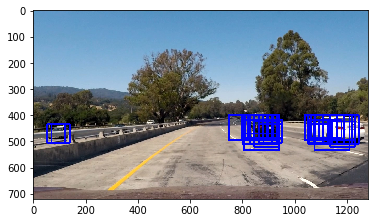

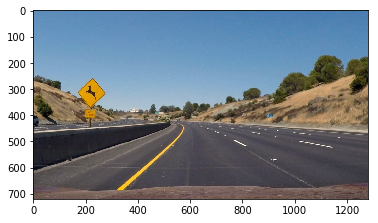

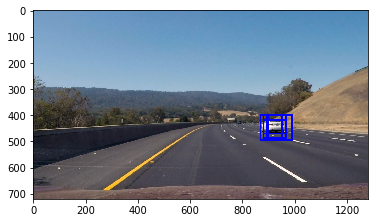

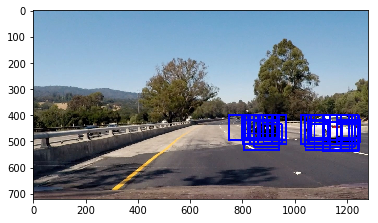

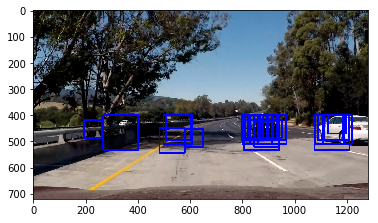

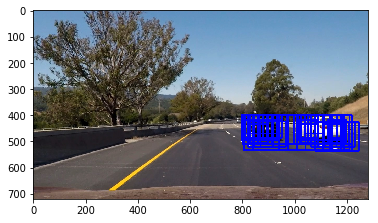

In [120]:
test_images = glob.glob('test_images/*.jpg')
count = 0
final_images, final_found_boxes = [], []

for test_image_path in test_images:
    count += 1
    image = mpimg.imread(test_image_path)

    found_boxes = store_all_found_boxes(image, window_scales)
    final_image = overlay_boxes(image, found_boxes)
    final_images.append(final_image)
    final_found_boxes.append(found_boxes)
    cv2.imwrite("output_images/BoxedOutput%d.jpg" % count, convert_BGR_to_RGB(final_image))     # save frame as JPEG file

for i in range(len(final_images)):
    plt.figure()
    plt.imshow(final_images[i])

# Handling Multiple Detections & False Positives

<p>Now, in order to improve the reliability of the classifier, I implemented the use of the **Heatmap** technique as described in the lessons. In order to increase its effectiveness, I tuned/ applied thresholding to the heatmap where anything below the threshold/ false positives are particularly ignored. The two sets of images below illustrates the effect of different thresholds particularly threshold values 2 and 4 and particularly test_image 4. Using a lower threshold, it can be seen that some part of the road is still visible on the heatmap. However, when using a threshold of 4, that particular area of the image has been completely filtered out and is no longer visible.</p>

<p> Using the scipy.ndimage.measurements.label(), I identified the corresponding "heated blobs" in the heatmap. Then, using the **draw_labeled_boxes** function, a bounding box based on min/max x and y is drawn over the image. </p>



In [56]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

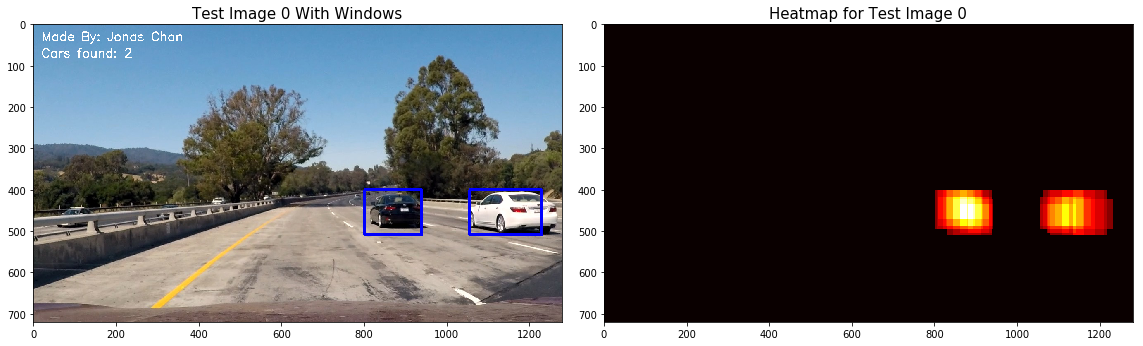

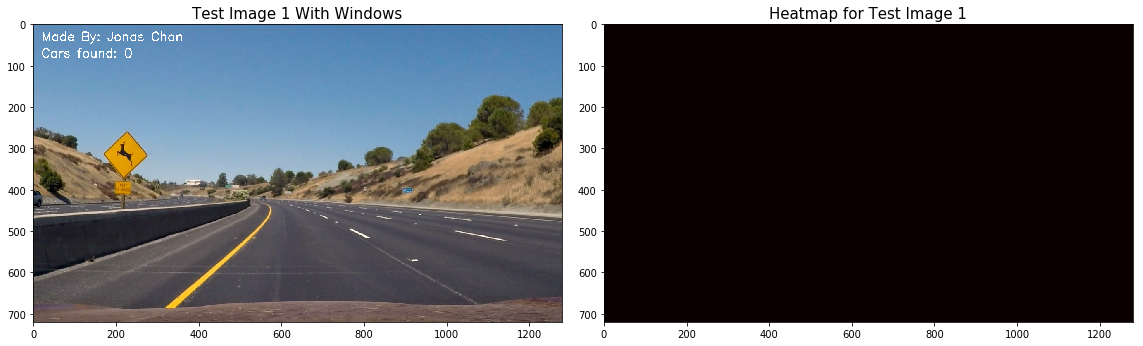

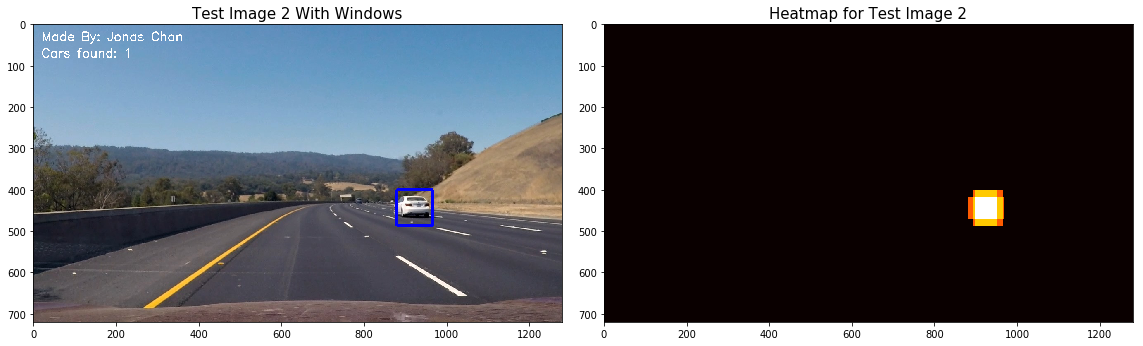

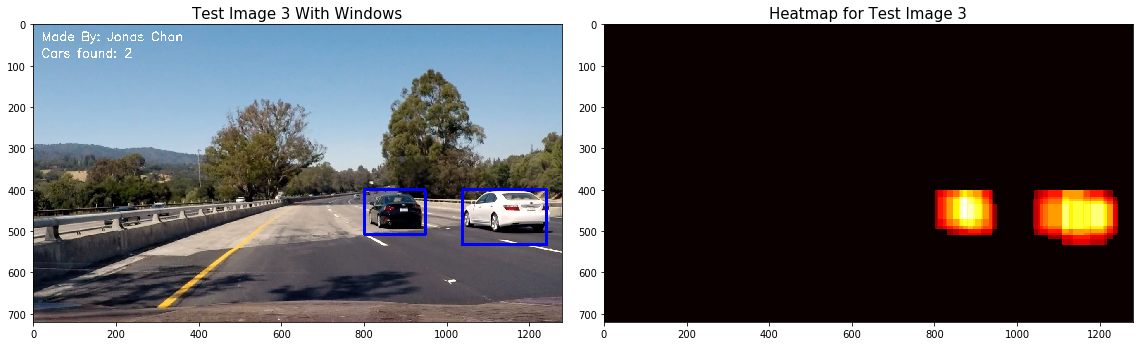

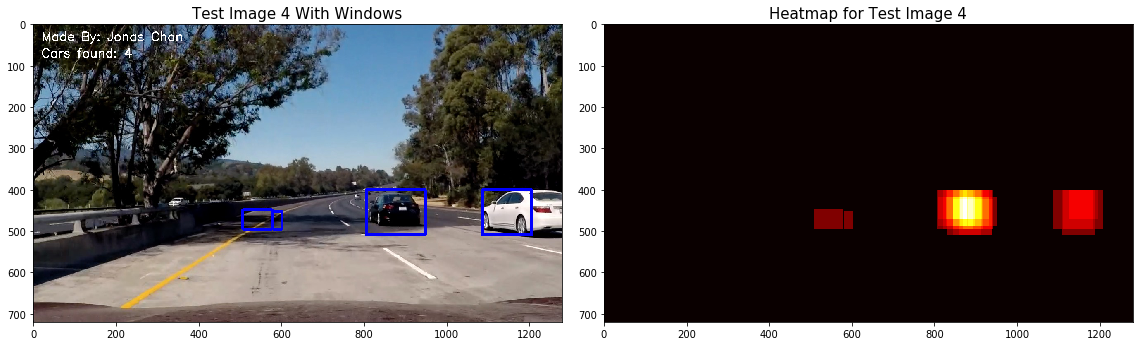

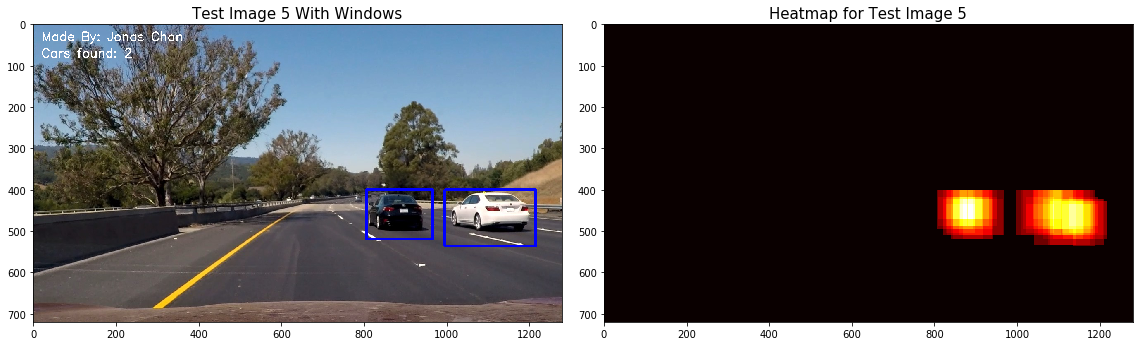

In [124]:
final_boxed_output = []
final_boxed_output_heatmap = []
car_count = []

for img, box in zip(test_images, final_found_boxes):
    raw_test_image = mpimg.imread(img)
    
    heat = add_heat(np.zeros_like(raw_test_image[:,:,0]).astype(np.float), box)

    heat = apply_threshold(heat, 2)

    heatmap = np.clip(heat, 0, 255)

    labels = label(heatmap)
    car_count.append(labels[1])
    
    draw_img = draw_labeled_bboxes(np.copy(raw_test_image), labels)
    
    final_boxed_output.append(draw_img)
    final_boxed_output_heatmap.append(heatmap)

if(len(final_boxed_output) != 0):
    for i in range(len(final_boxed_output)):
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
        f.tight_layout()
        
        cv2.putText(final_boxed_output[i],'Made By: Jonas Chan',(20,40), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
        
        cv2.putText(final_boxed_output[i],'Cars found: %d' % car_count[i], (20,80), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
        
        ax1.set_title('Test Image %d With Windows' % i, fontsize = 15)
        ax1.imshow(final_boxed_output[i])
        ax2.set_title('Heatmap for Test Image %d' % i, fontsize = 15)
        ax2.imshow(final_boxed_output_heatmap[i], cmap = 'hot')
        plt.savefig('output_images/Final_Output_%d.jpg' % i)

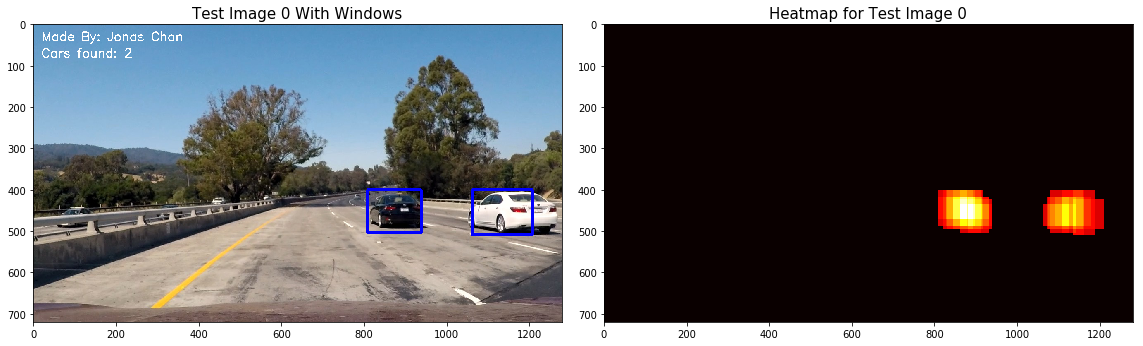

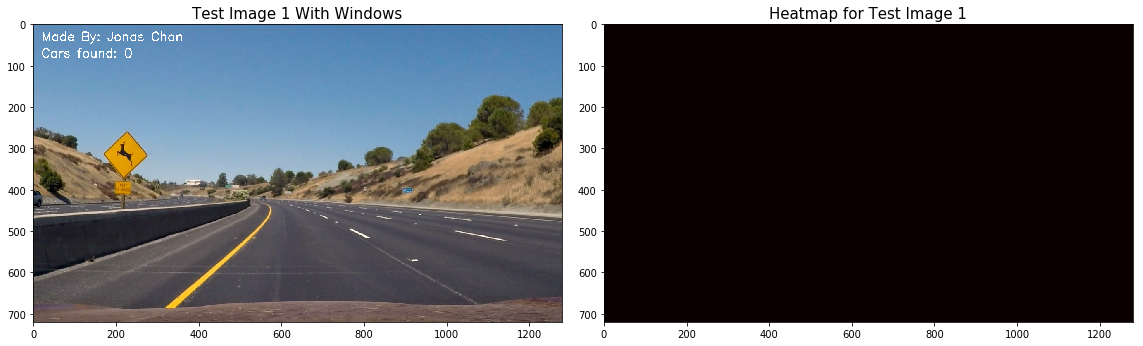

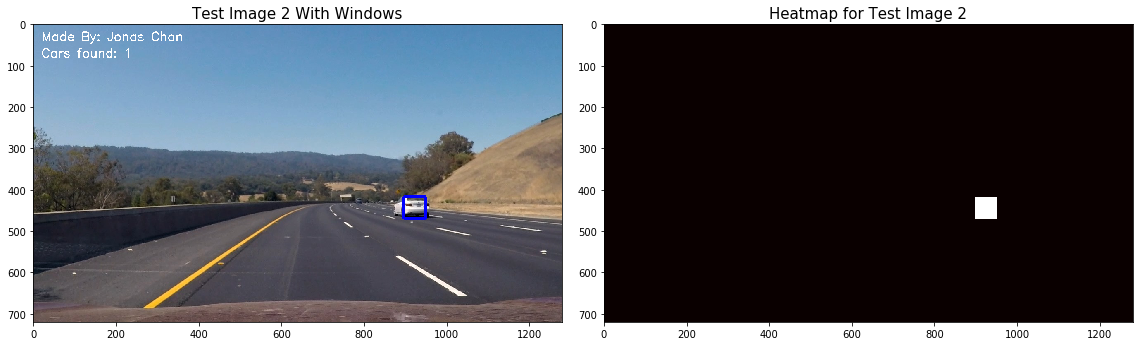

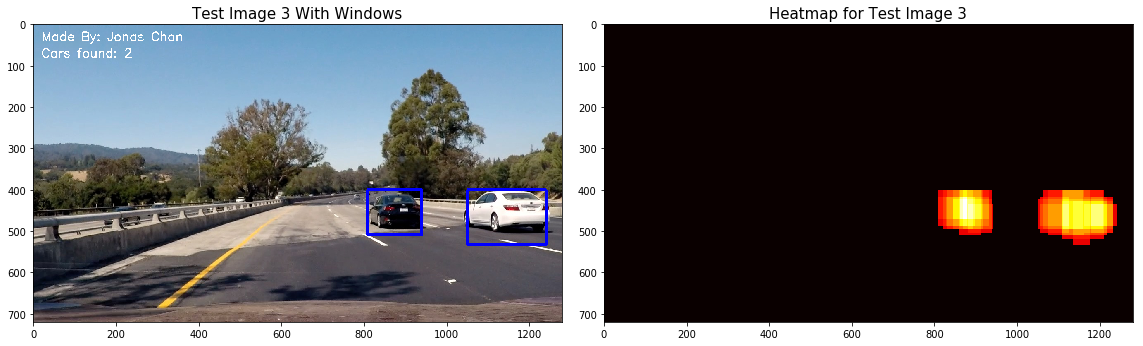

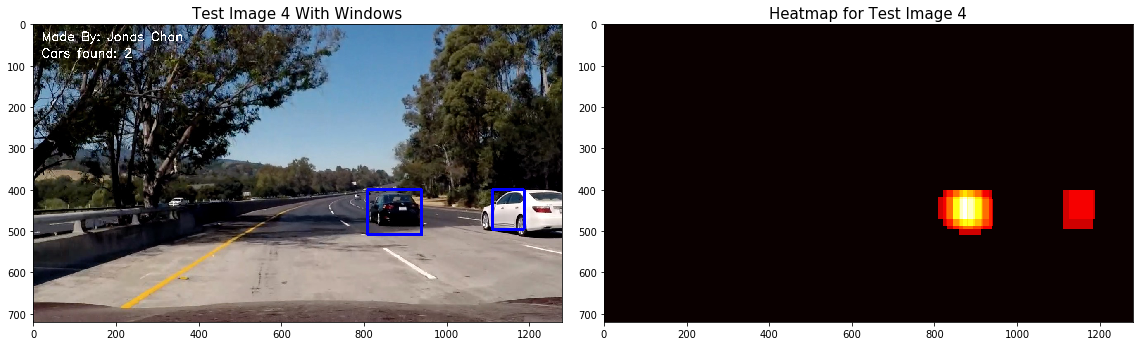

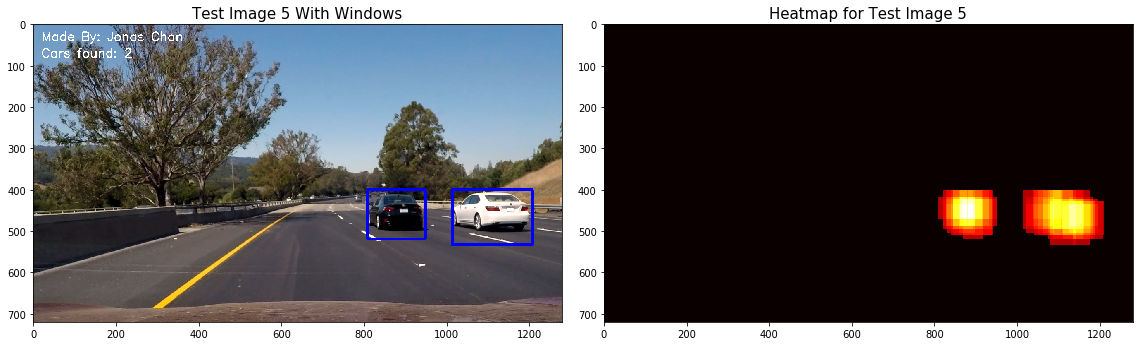

In [122]:
final_boxed_output = []
final_boxed_output_heatmap = []
car_count = []

for img, box in zip(test_images, final_found_boxes):
    raw_test_image = mpimg.imread(img)
    
    heat = add_heat(np.zeros_like(raw_test_image[:,:,0]).astype(np.float), box)

    heat = apply_threshold(heat, 4)

    heatmap = np.clip(heat, 0, 255)

    labels = label(heatmap)
    car_count.append(labels[1])
    
    draw_img = draw_labeled_bboxes(np.copy(raw_test_image), labels)
    
    final_boxed_output.append(draw_img)
    final_boxed_output_heatmap.append(heatmap)

if(len(final_boxed_output) != 0):
    for i in range(len(final_boxed_output)):
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
        f.tight_layout()
        
        cv2.putText(final_boxed_output[i],'Made By: Jonas Chan',(20,40), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
        
        cv2.putText(final_boxed_output[i],'Cars found: %d' % car_count[i], (20,80), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
        
        ax1.set_title('Test Image %d With Windows' % i, fontsize = 15)
        ax1.imshow(final_boxed_output[i])
        ax2.set_title('Heatmap for Test Image %d' % i, fontsize = 15)
        ax2.imshow(final_boxed_output_heatmap[i], cmap = 'hot')
        plt.savefig('output_images/Final_Output_%d.jpg' % i)


# Vehicle Detection Pipeline

Here, I combined all the methods used above in a single function called **vehicle_detection_pipeline** to search and identify the vehicles. To illustrate the pipeline working correctly, the second cell block below was used to test its functionality

In [58]:
def vehicle_detection_pipeline(img):    
    found_boxes = store_all_found_boxes(img, window_scales)
    
    heat = add_heat(np.zeros_like(img[:,:,0]).astype(np.float), found_boxes)
    
    heat_thresholded = apply_threshold(heat, 4)
    
    heatmap = np.clip(heat_thresholded, 0, 255)
    
    labels = label(heatmap)
    
    final_image = draw_labeled_bboxes(np.copy(img), labels)
    
    cv2.putText(final_image,'Made By: Jonas Chan',(20,40), 
                cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
        
    cv2.putText(final_image,'Cars found: %d' % labels[1], (20,80), 
                cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    
    return final_image

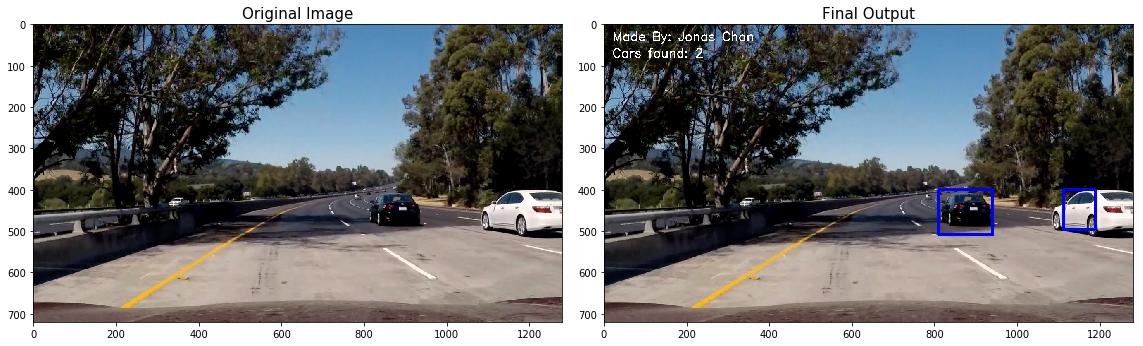

In [59]:
image = mpimg.imread('test_images/test5.jpg')
output = vehicle_detection_pipeline(image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
f.tight_layout()

ax1.set_title('Original Image', fontsize = 15)
ax1.imshow(image)
ax2.set_title('Final Output', fontsize = 15)
ax2.imshow(output)

# Video Stream Processing

Here I pass a stream of the project video into the pipeline for processing. The output video is in the submission folder and is titled "output.mp4"

In [60]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output_video = 'output.mp4'
clip = VideoFileClip('project_video.mp4')
project_video_clip = clip.fl_image(vehicle_detection_pipeline)
%time project_video_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [42:40<00:01,  1.77s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 32min 16s, sys: 1min 49s, total: 34min 5s
Wall time: 42min 42s
